In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from collections import Counter
from itertools import product
from tqdm import tqdm

In [ ]:
# !unzip "ml-latest-small.zip"

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


In [ ]:
# File path for the ratings CSV
file_path = "./content/ml-latest-mall/ratings.csv"

ratings_df = pd.read_csv(file_path)

ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
# Load the ratings dataset manually
ratings_dataset = []
with open(file_path, "r") as file:
    next(file)  # Skip the header line
    for line in file:
        user_id, movie_id, rating, _ = line.strip().split(",")
        ratings_dataset.append((int(user_id), int(movie_id), float(rating)))


In [ ]:
# Create mappings for user IDs and movie IDs
USER_TO_IDX = {user_id: user_idx for user_idx, user_id in enumerate(ratings_df["userId"].unique())}
MOVIE_TO_IDX = {movie_id: movie_idx for movie_idx, movie_id in enumerate(ratings_df["movieId"].unique())}

# Reverse mappings for index-to-ID conversions
idx_to_user = list(USER_TO_IDX.keys())  # List of user IDs by index
idx_to_movie = list(MOVIE_TO_IDX.keys())  # List of movie IDs by index

In [ ]:
# Calculate the total number of unique users and movies
NUM_USERS = len(idx_to_user)
NUM_MOVIES = len(idx_to_movie)

# Output the number of users and movies
NUM_USERS, NUM_MOVIES

(610, 9724)

In [ ]:
# Initialize data structures to store user and movie data
USERS_DATA = [[] for _ in range(NUM_USERS)]  # Each user will have a list of (movieIdx, rating) tuples
MOVIES_DATA = [[] for _ in range(NUM_MOVIES)]  # Each movie will have a list of (userIdx, rating) tuples

# Populate USERS_DATA and MOVIES_DATA
for user_id, movie_id, rating in ratings_dataset:
    user_idx = USER_TO_IDX[user_id]
    movie_idx = MOVIE_TO_IDX[movie_id]
    USERS_DATA[user_idx].append((movie_idx, rating))
    MOVIES_DATA[movie_idx].append((user_idx, rating))

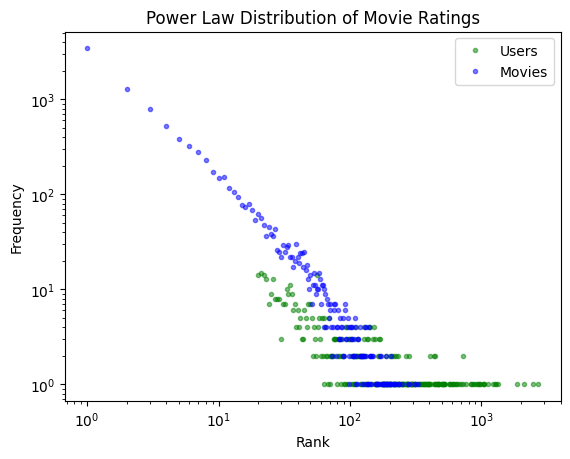

In [ ]:
# Calculate the number of ratings per movie and per user
ratings_per_movie = [len(movie_data) for movie_data in MOVIES_DATA]
ratings_per_user = [len(user_data) for user_data in USERS_DATA]

# Count the frequency of rating counts
user_rating_frequency = Counter(ratings_per_user)
movie_rating_frequency = Counter(ratings_per_movie)

# Plot the power law distribution for users and movies
plt.loglog(
    user_rating_frequency.keys(),
    user_rating_frequency.values(),
    ".",
    color="g",
    alpha=0.2,
    label="Users"
)
plt.loglog(
    movie_rating_frequency.keys(),
    movie_rating_frequency.values(),
    ".",
    color="b",
    alpha=0.2,
    label="Movies"
)

# Add labels, title, grid, and legend
plt.ylabel("Frequency")
plt.xlabel("Rank")
plt.title("Power Law Distribution of Movie Ratings")
plt.grid(linestyle='--', alpha=0.7)
plt.legend()
plt.show()


In [ ]:
def init_empty_data(size):
    """
    Initializes a list of empty lists with a specified size.

    Parameters:
    size (int): The number of empty lists to create.

    Returns:
    list: A list of empty lists.
    """
    return [[] for _ in range(size)]

def create_user_ds(user_data):
    """
    Creates user-specific datasets for watched movies and given ratings.

    Parameters:
    user_data (list): A list of user interactions with movies.

    Returns:
    tuple: Two lists - one with movie IDs watched by each user and one with their corresponding ratings.
    """
    users_watched_movies = [[] for _ in range(len(user_data))]
    users_given_ratings = [[] for _ in range(len(user_data))]

    for user_idx, user_movies in enumerate(user_data):
        users_watched_movies[user_idx] = [movie_id for movie_id, _ in user_movies]
        users_given_ratings[user_idx] = [rating for _, rating in user_movies]

    return users_watched_movies, users_given_ratings

def create_movie_ds(movie_data):
    """
    Creates movie-specific datasets for users who watched and their ratings.

    Parameters:
    movie_data (list): A list of movie interactions with users.

    Returns:
    tuple: Two lists - one with user IDs who watched each movie and one with their corresponding ratings.
    """
    movies_watched_by_users = [[] for _ in range(len(movie_data))]
    movies_received_ratings = [[] for _ in range(len(movie_data))]

    for movie_idx, movie_users in enumerate(movie_data):
        movies_watched_by_users[movie_idx] = [user_id for user_id, _ in movie_users]
        movies_received_ratings[movie_idx] = [rating for _, rating in movie_users]

    return movies_watched_by_users, movies_received_ratings

def split_data(data, test_ratio):
    """
    Splits the data into training and testing sets based on a given ratio.

    Parameters:
    data (list): The data to be split.
    test_ratio (float): The proportion of data to allocate to the test set.

    Returns:
    tuple: Training and testing datasets.
    """
    train, test = init_empty_data(len(data)), init_empty_data(len(data))

    for idx, interactions in enumerate(data):
        for interaction in interactions:
            if np.random.rand() > test_ratio:
                train[idx].append(interaction)
            else:
                test[idx].append(interaction)

    return train, test


def split(users_data, movies_data, test_ratio=0.1):
    """
    Splits user and movie data into training and testing sets.

    Parameters:
    users_data (list): User interaction data.
    movies_data (list): Movie interaction data.
    test_ratio (float): Proportion of data to allocate to the test set (default is 0.1).

    Returns:
    tuple: Training and testing datasets as dictionaries.
    """
    # Split user and movie data
    users_data_train, users_data_test = split_data(users_data, test_ratio)
    movies_data_train, movies_data_test = split_data(movies_data, test_ratio)

    # Train data
    train_data = {
        "users_watched_movies": create_user_ds(users_data_train)[0],
        "users_given_ratings": create_user_ds(users_data_train)[1],
        "movies_watched_by_users": create_movie_ds(movies_data_train)[0],
        "movies_received_ratings": create_movie_ds(movies_data_train)[1]
    }

    # Test data
    test_data = {
        "users_watched_movies": create_user_ds(users_data_test)[0],
        "users_given_ratings": create_user_ds(users_data_test)[1],
        "movies_watched_by_users": create_movie_ds(movies_data_test)[0],
        "movies_received_ratings": create_movie_ds(movies_data_test)[1]
    }

    return train_data, test_data

In [ ]:
def init_biases(num_users, num_movies):
    """
    Initializes biases for users and movies.

    Parameters:
    num_users (int): Number of users.
    num_movies (int): Number of movies.

    Returns:
    tuple: Arrays of user biases and movie biases initialized to zero.
    """
    user_biases = np.zeros(num_users)
    movie_biases = np.zeros(num_movies)
    return user_biases, movie_biases

def init_latent_matrices(num_users, num_movies, k, seed=None):
    """
    Initializes latent matrices for users and movies.

    Parameters:
    num_users (int): Number of users.
    num_movies (int): Number of movies.
    k (int): Number of latent factors.
    seed (int, optional): Random seed for reproducibility. Default is None.

    Returns:
    tuple: User latent matrix and movie latent matrix.
    """
    if seed is not None:
        np.random.seed(seed)

    # Initialize latent matrices with random values scaled by 1/sqrt(k)
    user_latents = np.random.normal(size=(num_users, k), scale=1 / np.sqrt(k))
    movie_latents = np.random.normal(size=(num_movies, k), scale=1 / np.sqrt(k))

    return user_latents, movie_latents


def update_users_biases(users_movies_data, users_ratings_data, movie_biases, lambda_, gamma):
    """
    Updates user biases based on observed ratings and movie biases.

    Parameters:
    users_movies_data (list): List of movies rated by each user.
    users_ratings_data (list): List of ratings given by each user.
    movie_biases (ndarray): Array of movie biases.
    lambda_ (float): Regularization parameter.
    gamma (float): Weight parameter.

    Returns:
    None: Updates user_biases in place.
    """
    for i in range(len(users_movies_data)):
        user_movies = users_movies_data[i]  # Movies rated by the user
        user_ratings = users_ratings_data[i]  # Ratings given by the user
        num_movies = len(user_movies)  # Number of movies rated by the user
        if num_movies > 0:
            user_biases[i] = lambda_ * np.sum(user_ratings - movie_biases[user_movies]) / (lambda_ * num_movies + gamma)


def update_movies_biases(movies_users_data, movies_ratings_data, user_biases, lambda_, gamma):
    """
    Updates movie biases based on observed ratings and user biases.

    Parameters:
    movies_users_data (list): List of users who rated each movie.
    movies_ratings_data (list): List of ratings received by each movie.
    user_biases (ndarray): Array of user biases.
    lambda_ (float): Regularization parameter.
    gamma (float): Weight parameter.

    Returns:
    None: Updates movie_biases in place.
    """
    for i in range(len(movies_users_data)):
        movie_users = movies_users_data[i]  # Users who rated the movie
        movie_ratings = movies_ratings_data[i]  # Ratings given to the movie
        num_users = len(movie_users)  # Number of users who rated the movie
        if num_users > 0:
            movie_biases[i] = lambda_ * np.sum(movie_ratings - user_biases[movie_users]) / (lambda_ * num_users + gamma)


def update_user_latents(users_movies_data, users_ratings_data, user_biases, movie_biases, U, V, lambda_, tau, k):
    """
    Updates user latent factor matrices.

    Parameters:
    users_movies_data (list): List of movies rated by each user.
    users_ratings_data (list): List of ratings given by each user.
    user_biases (ndarray): Array of user biases.
    movie_biases (ndarray): Array of movie biases.
    U (ndarray): User latent matrix.
    V (ndarray): Movie latent matrix.
    lambda_ (float): Regularization parameter.
    tau (float): Weight parameter for the identity matrix.
    k (int): Number of latent factors.

    Returns:
    None: Updates U in place.
    """
    for i in range(len(users_movies_data)):
        user_movies = users_movies_data[i]  # Movies rated by user i
        user_ratings = users_ratings_data[i]  # Ratings given by user i

        # Regularization term
        inv_term = lambda_ * np.dot(V[user_movies].T, V[user_movies]) + tau * np.eye(k)

        # Term involving ratings and biases
        term = lambda_ * np.dot(
            V[user_movies].T,
            user_ratings - movie_biases[user_movies] - user_biases[i]
        )

        # Update user latent factors
        U[i] = np.dot(np.linalg.inv(inv_term), term)

def update_movie_latents(movies_users_data, movies_ratings_data, user_biases, movie_biases, U, V, lambda_, tau, k):
    """
    Updates movie latent factor matrices.

    Parameters:
    movies_users_data (list): List of users who rated each movie.
    movies_ratings_data (list): List of ratings received by each movie.
    user_biases (ndarray): Array of user biases.
    movie_biases (ndarray): Array of movie biases.
    U (ndarray): User latent matrix.
    V (ndarray): Movie latent matrix.
    lambda_ (float): Regularization parameter.
    tau (float): Weight parameter for the identity matrix.
    k (int): Number of latent factors.

    Returns:
    None: Updates V in place.
    """
    for i in range(len(movies_users_data)):
        movie_users = movies_users_data[i]  # Users who rated movie i
        movie_ratings = movies_ratings_data[i]  # Ratings given to movie i

        # Regularization term
        inv_term = lambda_ * np.dot(U[movie_users].T, U[movie_users]) + tau * np.eye(k)

        # Term involving ratings and biases
        term = lambda_ * np.dot(
            U[movie_users].T,
            movie_ratings - user_biases[movie_users] - movie_biases[i]
        )

        # Update movie latent factors
        V[i] = np.dot(np.linalg.inv(inv_term), term)

def calc_loss(users_movies_data, users_ratings_data, user_biases, movie_biases, U, V, lambda_, gamma, tau):
    """
    Calculates the RMSE and total loss for the current state of latent factors and biases.

    Parameters:
    users_movies_data (list): List of movies rated by each user.
    users_ratings_data (list): List of ratings given by each user.
    user_biases (ndarray): Array of user biases.
    movie_biases (ndarray): Array of movie biases.
    U (ndarray): User latent matrix.
    V (ndarray): Movie latent matrix.
    lambda_ (float): Regularization parameter for error term.
    gamma (float): Regularization parameter for biases.
    tau (float): Regularization parameter for latent matrices.

    Returns:
    tuple: RMSE (float) and total loss (float).
    """
    total_error = 0.0
    num_ratings = 0

    # Calculate total error and number of ratings
    for i in range(len(users_movies_data)):
        user_ratings = np.array(users_ratings_data[i], dtype=np.float32)
        user_movies = np.array(users_movies_data[i], dtype=np.int32)
        num_ratings += len(user_movies)

        # Predicted ratings
        preds = np.dot(V[user_movies], U[i]) + user_biases[i] + movie_biases[user_movies]

        # Accumulate squared error
        total_error += np.sum((user_ratings - preds) ** 2)

    # Compute RMSE
    rmse = np.sqrt(total_error / num_ratings)

    # Compute total loss with regularization
    loss = (
        (lambda_ / 2) * total_error
        + (tau / 2) * (np.sum(U ** 2) + np.sum(V ** 2))
        + (gamma / 2) * (np.sum(user_biases ** 2) + np.sum(movie_biases ** 2))
    )

    return rmse, loss


In [ ]:
# users data
users_watched_movies_train = train_data["users_watched_movies"]
users_given_ratings_train = train_data["users_given_ratings"]

users_watched_movies_test = test_data["users_watched_movies"]
users_given_ratings_test = test_data["users_given_ratings"]

# movies data
movies_watched_by_users_train = train_data["movies_watched_by_users"]
movies_received_ratings_train = train_data["movies_received_ratings"]

movies_watched_by_users_test = test_data["movies_watched_by_users"]
movies_received_ratings_test = test_data["movies_received_ratings"]

In [ ]:
def train_fn(users_watched_movies_train, users_given_ratings_train,
             movies_watched_by_users_train,
             movies_received_ratings_train,
            users_watched_movies_test,
             users_given_ratings_test,
            user_biases,
            movie_biases,
            U, V,
            lambda_,gamma,tau,k, iterations):
    rmse_train_losses, rmse_test_losses, losses = [], [], []
    for i in range(iterations):

        update_users_biases(users_watched_movies_train, users_given_ratings_train, movie_biases, U_matrix, V_matrix, lambda_, gamma)
        update_user_latents(users_watched_movies_train, users_given_ratings_train, user_biases, movie_biases, U_matrix, V_matrix, lambda_, tau, k)

        update_movies_biases(movies_watched_by_users_train, movies_received_ratings_train, user_biases, U_matrix, V_matrix, lambda_, gamma)
        update_movie_latents(movies_watched_by_users_train, movies_received_ratings_train, user_biases, movie_biases, U_matrix, V_matrix, lambda_, tau, k)
        # train losses
        rmse_train,loss_train = calc_loss(users_watched_movies_train, users_given_ratings_train, user_biases, movie_biases, U_matrix, V_matrix, lambda_, gamma, tau)
        # test losses
        rmse_test,_ = calc_loss(users_watched_movies_test, users_given_ratings_test, user_biases, movie_biases,U_matrix, V_matrix, lambda_, gamma, tau)
        rmse_train_losses.append(rmse_train);rmse_test_losses.append(rmse_test);losses.append(loss_train)



    return rmse_train_losses, rmse_test_losses, losses

In [ ]:
lambda_values = [0.01, 0.05, 0.1, 0.5]
tau_values = [0.1, 0.5, 1.0, 1.5]
gamma_values = [0.01, 0.1, 0.5]

# Generate all combinations of hyperparameters
params = list(product(lambda_values, tau_values, gamma_values))

# Dictionary to store RMSE results for test data
rmse_test_values = {}

# Grid search
for _, (lambda_, tau, gamma) in tqdm(enumerate(params)):
    # Initialize biases and latent matrices
    user_biases, movie_biases = init_biases(NUM_USERS, NUM_MOVIES)
    U_matrix, V_matrix = init_latent_matrices(NUM_USERS, NUM_MOVIES, k, seed=101)

    # Train the model and retrieve test RMSE
    _, rmse_test, _ = train_fn(
        users_watched_movies_train, users_given_ratings_train,
        movies_watched_by_users_train, movies_received_ratings_train,
        users_watched_movies_test, users_given_ratings_test,
        user_biases, movie_biases, U_matrix, V_matrix,
        lambda_, gamma, tau, k, iterations=10
    )

    # Store the test RMSE for the current combination of hyperparameters
    rmse_test_values[(lambda_, tau, gamma)] = rmse_test




48it [04:05,  5.12s/it]


In [ ]:
# Define iterations for the x-axis
iterations = np.arange(1, 11)

# Plot the test RMSE values for each combination of hyperparameters
for (lambda_, tau, gamma), rmse_test in rmse_test_values.items():
    # Skip hyperparameter combinations with a minimum RMSE > 0.58 to be more readable
    if min(rmse_test) > 0.58:
        continue

    # Plot RMSE across iterations for the current combination
    plt.plot(
        iterations,
        rmse_test,
        "--",
        label=rf"$\lambda$: {lambda_}, $\tau$: {tau}, $\gamma$: {gamma}"
    )

# Add labels, title, and legend
plt.xlabel("Iterations")
plt.ylabel("Test RMSE")
plt.title("Hyperparameters Grid Search")
plt.legend()
plt.show()

TypeError: cannot unpack non-iterable int object

In [ ]:
# Define the best hyperparameters and range of k-values
best_lambda = 0.1
best_gamma = 0.01
best_tau = 0.1
k_values = [2, 4, 8, 16, 32, 64, 128, 256, 512]

# Dictionary to store RMSE results for each k-value
rmse_test_values = {}

# Iterate over k-values
for _, k_value in tqdm(enumerate(k_values), total=len(k_values)):
    # Initialize biases and latent matrices
    user_biases, movie_biases = init_biases(NUM_USERS, NUM_MOVIES)
    U_matrix, V_matrix = init_latent_matrices(NUM_USERS, NUM_MOVIES, k_value, seed=101)

    # Train the model and retrieve RMSE for test data
    _, rmse_test, _ = train_fn(
        users_watched_movies_train, users_given_ratings_train,
        movies_watched_by_users_train, movies_received_ratings_train,
        users_watched_movies_test, users_given_ratings_test,
        user_biases, movie_biases, U_matrix, V_matrix,
        best_lambda, best_gamma, best_tau, k_value, iterations=10
    )

    # Store the test RMSE for the current k-value
    rmse_test_values[k_value] = rmse_test


9it [17:04, 113.81s/it]


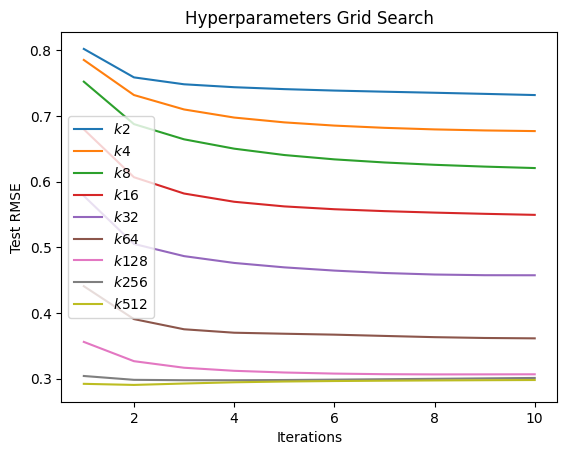

In [ ]:
# x-axis
iterations = np.arange(1, 11)

for k_value, rmse_test in rmse_test_values.items():

    plt.plot(
        iterations,
        rmse_test[:10],
        label=f"$k$={k_value}"
    )

plt.xlabel("Iterations")
plt.ylabel("Test RMSE")
plt.title("Hyperparameters Grid Search Across k Values")
plt.legend()
plt.show()

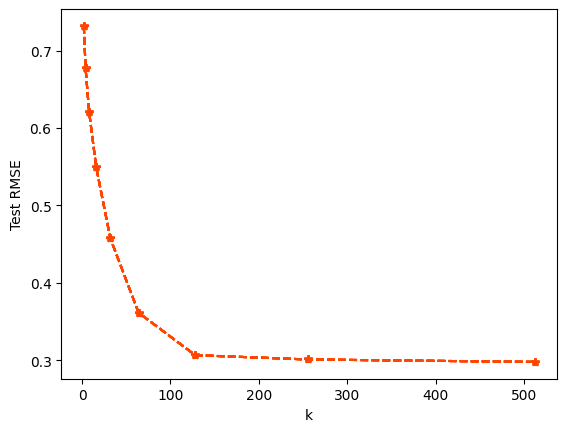

In [ ]:
# Extract k-values and the last RMSE values
k_values = list(rmse_test_values.keys())
last_rmse_values = [rmse_test[-1] for rmse_test in rmse_test_values.values()]

plt.plot(
    k_values,
    last_rmse_values,
    "--*",
    color="orangered",
    label="Last RMSE Value"
)

plt.xlabel("k (Number of Latent Factors)")
plt.ylabel("Test RMSE")
plt.savefig("100k_latent_length_new.svg")
plt.show()